In [1]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import pymysql
pymysql.install_as_MySQLdb()

import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from flask import Flask, jsonify

*start and end dates were removed into the Temperature Analysis paragraph*

**Create engine**

In [2]:
engine = create_engine('sqlite:///../Base/hawaii.sqlite')

In [3]:
#check if everything works
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

**Check tables and column names**

In [4]:
inspector = inspect(engine)

In [5]:
tables = {} # keep all tables and columns. maybe useless
for table in inspector.get_table_names():
    print(f'Table name is "{table}", it contains columns: ')
    columns = inspector.get_columns(table)
    names = []
    for c in columns:
        names.append(c['name'])
        print(c['name'], c['type'])
    print()
    tables[table] = names

Table name is "measurement", it contains columns: 
id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER

Table name is "station", it contains columns: 
id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT



**Declare a Base using automap and reflect database**

In [6]:
Base = automap_base()
Base.prepare(engine, reflect=True)

**Assign classes to variables**

In [7]:
Measurement = Base.classes.measurement
Station = Base.classes.station

## Precipitation Analysis

**Start a session to make queries**

In [8]:
session = Session(engine)

**Get information for the last year**

In [9]:
#find the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#convert string to df format
date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
#subtract 365 days
year_ago = date - dt.timedelta(days=365)

In [10]:
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

**Create DF and plot it**

In [11]:
df = pd.DataFrame(last_year_prcp, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


Text(0,0.5,'Precipitation')

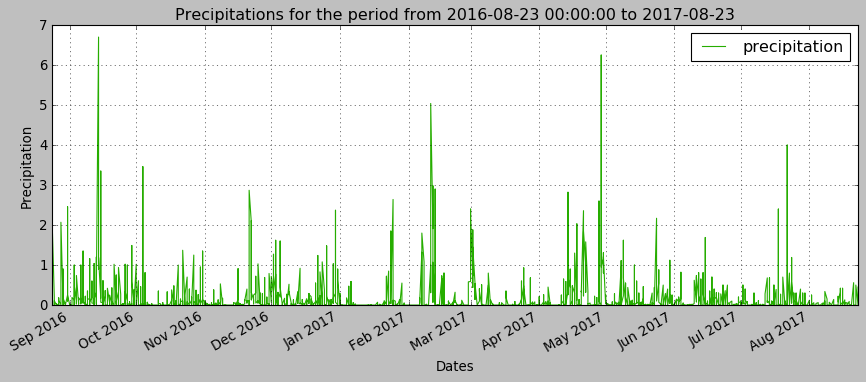

In [12]:
plt.style.use('classic')
ax = df.plot(title=f'Precipitations for the period from {year_ago} to {last_date[0][0:10]}', color='#26ad00',\
             grid=True, figsize=(13,5))
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation')

**Get percipitation statistics**

In [13]:
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [14]:
# Total # of stations
session.query(Measurement.station).distinct().count()

9

In [15]:
# List of stations activity
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [16]:
# Most active station
most_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
most_active

('USC00519281')

In [17]:
last_year_temp = session.query(Measurement.tobs).filter(Measurement.date > year_ago).\
                    filter(Measurement.station == most_active[0]).all()

In [18]:
df = pd.DataFrame(last_year_temp, columns=['Temperature'])

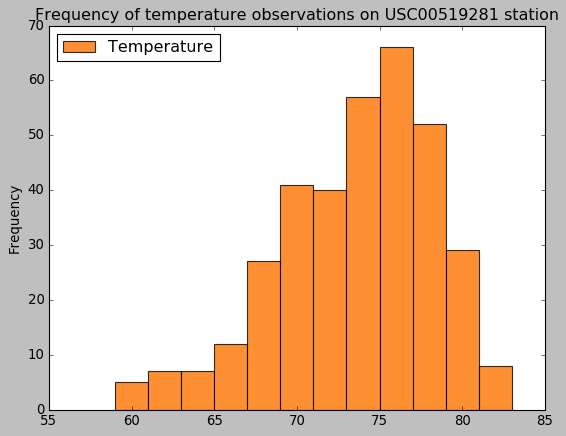

In [19]:
df.plot.hist(by='Temperature', bins=12, color='#ff7300',\
             title=f'Frequency of temperature observations on {most_active[0]} station', alpha=0.8)

## Temperature Analysis

**Create a function**

In [20]:
start_date = dt.datetime.strptime(input('Enter start date in format %Y-%m-%d'), "%Y-%m-%d")
end_date = dt.datetime.strptime(input('Enter end date in format %Y-%m-%d'), "%Y-%m-%d")

Enter start date in format %Y-%m-%d2017-03-25
Enter end date in format %Y-%m-%d2017-04-07


In [21]:
def calc_temps(start, end):
    '''Calculates minimun, average and maximum temperature for a period of dates
    start and end dates should be in a datetime format'''
    query = session.query((func.min(Measurement.tobs)), (func.avg(Measurement.tobs)), (func.max(Measurement.tobs))).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    tempts = [x for x in query[0]]
    return tempts

**Find 'a year ago' temperatures**

In [22]:
a_year_ago_temps = calc_temps(start_date - dt.timedelta(days=365), end_date - dt.timedelta(days=365))

**Plot it**

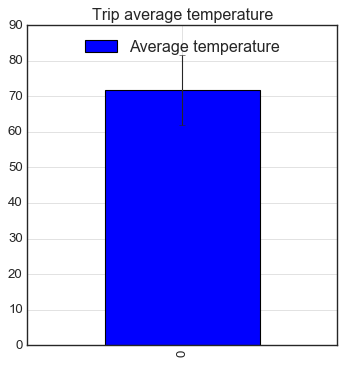

In [23]:
plt.style.use('seaborn-white')
dfy = pd.DataFrame(a_year_ago_temps).transpose()
err=[dfy[0] - dfy[1], dfy[2] - dfy[1]]
ax = dfy.plot.bar(y=1, yerr=err, grid=True, title='Trip average temperature', label='Average temperature',\
                 figsize=(5,5))
ax.legend(loc=9)

**Easier way to plot**

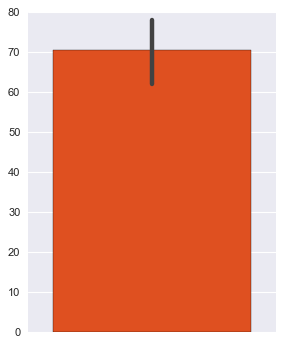

In [24]:
sns.set(rc={'figure.figsize':(4,5)})
sns.barplot(y=a_year_ago_temps, color='#ff4000', errwidth=4)

## Optional Recommended Analysis

In [25]:
#rainfall per weather station
session.query(Measurement.station, func.sum(Measurement.prcp)).filter((Measurement.date > year_ago)).\
group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 147.11000000000004),
 ('USC00519281', 68.24000000000002),
 ('USC00513117', 48.36000000000003),
 ('USC00519523', 37.99),
 ('USC00514830', 33.19),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]

**Define a function**

In [26]:
def daily_normals(day):
    '''Calculates minimun, average and maximum temperature for a particular day taking into account all years.
    day - a string in format '%m-%d' '''
    day_dt = dt.datetime.strptime(day, '%m-%d')
    tempts = session.query((func.min(Measurement.tobs)), (func.avg(Measurement.tobs)), (func.max(Measurement.tobs))).\
    filter(func.strftime('%m', Measurement.date) == day_dt.strftime('%m')).\
    filter(func.strftime('%d', Measurement.date) == day_dt.strftime('%d')).\
    all()
    res = [t for t in tempts[0]]
    return res

**Create a list of vacation days**

In [27]:
vacation_days_short = []
vacation_days = [dt.datetime.strptime(d[0], '%Y-%m-%d') for d in session.query(Measurement.date).\
          filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()]
for d in vacation_days:
    vacation_days_short.append(f'{d.month}-{d.day}')

**Create a dict of vacation temperatures**

In [28]:
vacation_temps = {}
for x in range(len(vacation_days_short)):
    vacation_temps[vacation_days[x]] = daily_normals(vacation_days_short[x])
    x += 1
vacation_temps

{datetime.datetime(2017, 3, 26, 0, 0): [64, 71.51063829787235, 80],
 datetime.datetime(2017, 3, 27, 0, 0): [63, 71.375, 77],
 datetime.datetime(2017, 3, 28, 0, 0): [59, 71.36734693877551, 78],
 datetime.datetime(2017, 3, 29, 0, 0): [58, 71.25490196078431, 77],
 datetime.datetime(2017, 3, 30, 0, 0): [62, 71.92307692307692, 78],
 datetime.datetime(2017, 3, 31, 0, 0): [61, 71.63461538461539, 79],
 datetime.datetime(2017, 4, 1, 0, 0): [61, 72.16363636363636, 80],
 datetime.datetime(2017, 4, 2, 0, 0): [53, 71.67307692307692, 79],
 datetime.datetime(2017, 4, 3, 0, 0): [55, 72.12962962962963, 78],
 datetime.datetime(2017, 4, 4, 0, 0): [58, 72.0, 78],
 datetime.datetime(2017, 4, 5, 0, 0): [61, 72.20689655172414, 80],
 datetime.datetime(2017, 4, 6, 0, 0): [67, 71.67307692307692, 77],
 datetime.datetime(2017, 4, 7, 0, 0): [63, 71.07692307692308, 78]}

**Put all in DF**

In [29]:
dfdn = pd.DataFrame(vacation_temps).transpose()
dfdn.columns=['tmin', 'tavg', 'tmax']
#dfdn.reset_index(inplace=True)
#dfdn['index'] = pd.to_datetime(dfdn['index'])
#dfdn = dfdn.set_index('index')
dfdn

,tmin,tavg,tmax
2017-03-26,64.0,71.510638,80.0
2017-03-27,63.0,71.375000,77.0
2017-03-28,59.0,71.367347,78.0
2017-03-29,58.0,71.254902,77.0
2017-03-30,62.0,71.923077,78.0
2017-03-31,61.0,71.634615,79.0
2017-04-01,61.0,72.163636,80.0
2017-04-02,53.0,71.673077,79.0
2017-04-03,55.0,72.129630,78.0
2017-04-04,58.0,72.000000,78.0


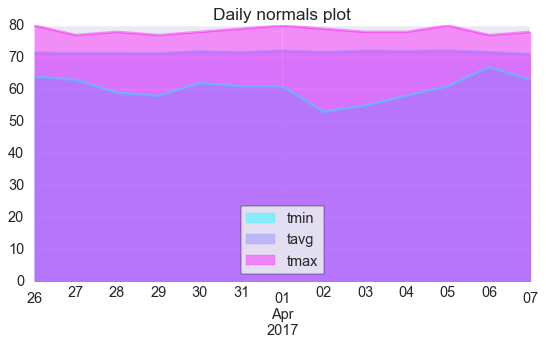

In [30]:
plt.style.use('seaborn-talk')
ax = dfdn.plot.area(stacked=False, figsize=(8,4), title='Daily normals plot', alpha=0.4,\
                    colormap='cool')
ax.legend(loc=8, frameon=True, framealpha=0.9, edgecolor='black')
#ax.xaxis.set_major_locator(mdates.DayLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#plt.gcf().autofmt_xdate()

## Step 4 - Climate App

**Please proceed to the weather_app.py**

In [ ]:
plt.style.available